In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm, trange


In [2]:
def load_episode_data(path):
    with open(path, "rb") as f:
        data = pickle.load(f)
    return data


datas = [
    load_episode_data(f"bo_evaluation/problem_{i:03d}/recorded_episode_1.pkl")
    for i in trange(300)
]


100%|██████████| 300/300 [00:00<00:00, 841.36it/s]


In [3]:
def extract_maes(data):
    beams = [obs["beam"] for obs in data]
    target = data[0]["target"]
    maes = np.mean(np.abs(np.array(beams) - np.array(target)), axis=1)

    return maes


data_maes = [extract_maes(data["observations"]) for data in datas]


In [4]:
def compute_min_maes(maes):
    min_maes = [np.min(maes[: i + 1]) for i in range(len(maes))]
    return min_maes


data_min_maes = [compute_min_maes(m) for m in data_maes]


In [5]:
final_maes = [m[-1] for m in data_min_maes]


### MAE Median (mm)

4.5300330384634435e-05


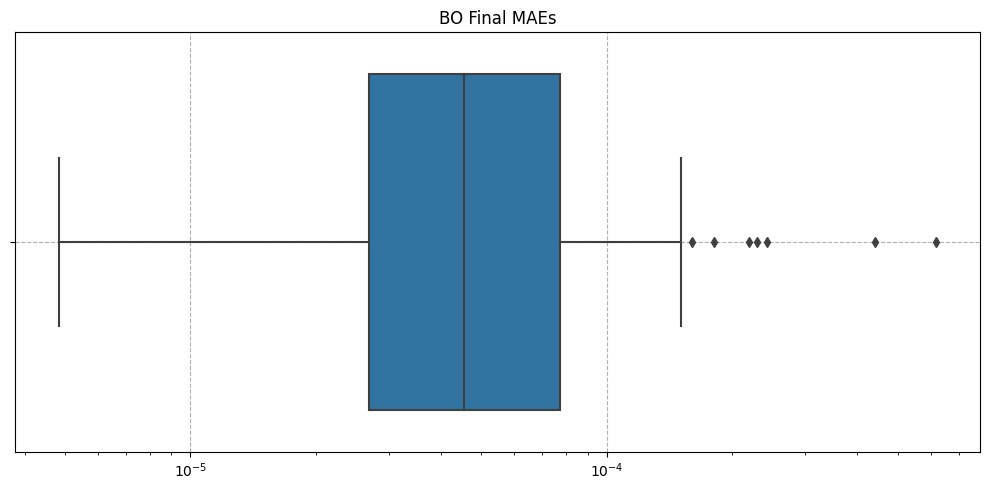

In [6]:
print(f"{np.median(final_maes)}")

plt.figure(figsize=(10, 5))
plt.title("BO Final MAEs")
sns.boxplot(x=final_maes)
plt.xscale("log")
# plt.gca().xaxis.grid()
plt.grid(ls="--")
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()


### Convergence Median (Steps)

In [7]:
df = pd.DataFrame(
    {"problem": [], "step": [], "mae": [], "min_mae": [], "algorithm": []}
)
for problem in trange(300):
    for step in range(150):
        df = pd.concat(
            [
                df,
                pd.DataFrame(
                    {
                        "problem": [problem],
                        "step": [step],
                        "mae": [data_maes[problem][step]],
                        "min_mae": [data_min_maes[problem][step]],
                        "algorithm": ["BO"],
                    }
                ),
            ]
        )


100%|██████████| 300/300 [00:14<00:00, 20.28it/s]


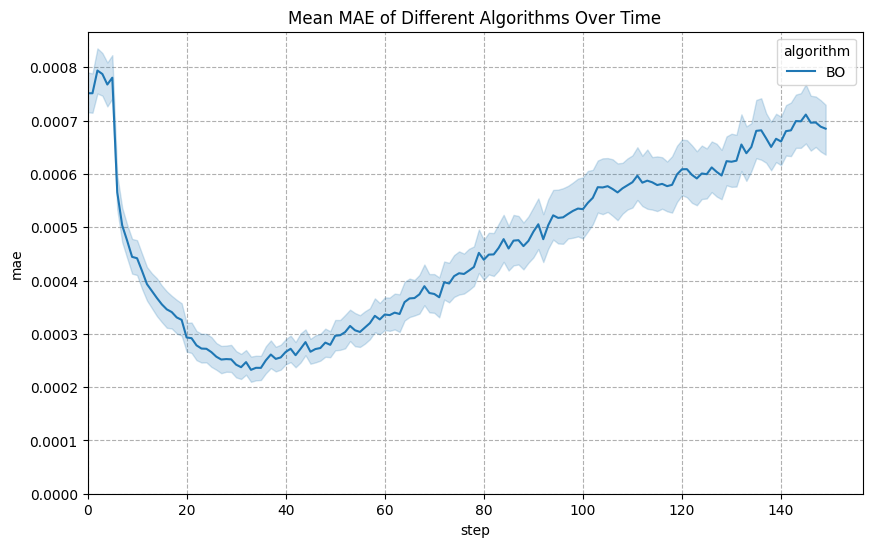

In [8]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="step", y="mae", hue="algorithm", data=df)
plt.title("Mean MAE of Different Algorithms Over Time")
plt.xlim(0, None)
plt.ylim(0, None)
plt.grid(ls="--")
plt.gca().set_axisbelow(True)
plt.show()


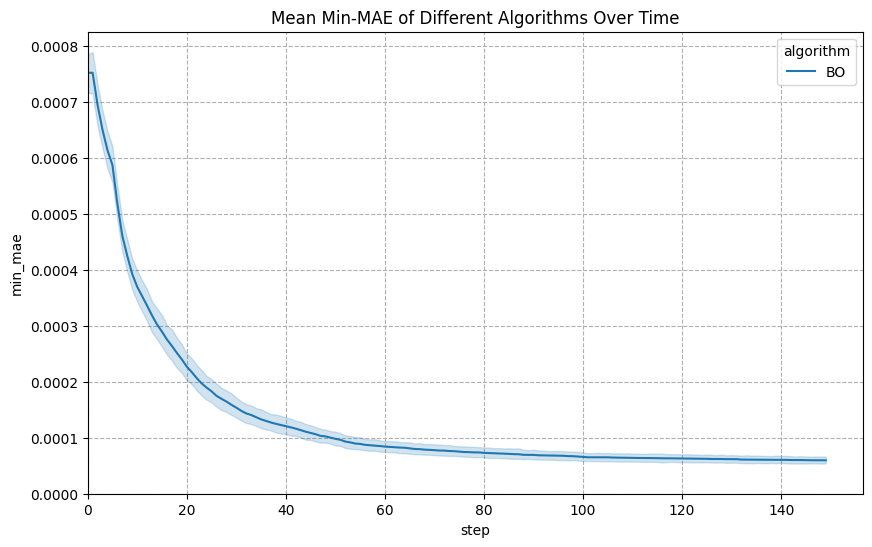

In [9]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="step", y="min_mae", hue="algorithm", data=df)
plt.title("Mean Min-MAE of Different Algorithms Over Time")
plt.xlim(0, None)
plt.ylim(0, None)
plt.grid(ls="--")
plt.gca().set_axisbelow(True)
plt.show()


In [10]:
convergence_limit = 3.3198e-6 * 4


In [11]:
def find_convergence(example):
    example = example.copy()
    example.set_index("step", inplace=True)
    example.sort_index(inplace=True)
    example["mae_diff"] = example["mae"].diff()
    example["abs_mae_diff"] = example["mae_diff"].abs()

    convergence_step = example.index.max()
    for i in example.index:
        x = all(example.loc[i:, "abs_mae_diff"] < convergence_limit)
        if x:
            convergence_step = i
            break

    return convergence_step


convsteps1 = df.groupby(["algorithm", "problem"]).apply(find_convergence)


In [12]:
convsteps1 = convsteps1.reset_index().rename(columns={0: "convergence"})
convsteps1.groupby("algorithm")["convergence"].median()


algorithm
BO    149.0
Name: convergence, dtype: float64

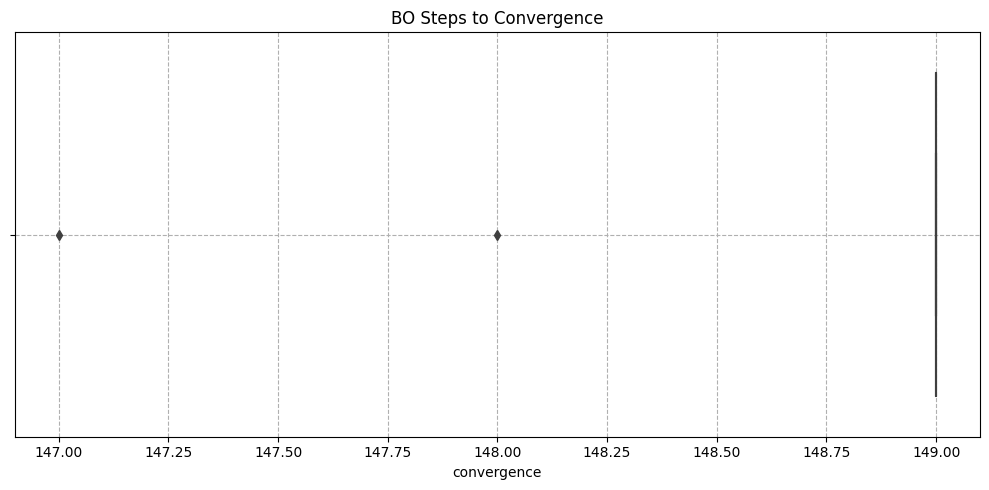

In [13]:
plt.figure(figsize=(10, 5))
plt.title("BO Steps to Convergence")
sns.boxplot(x="convergence", data=convsteps1)
# plt.xscale("log")
# plt.gca().xaxis.grid()
plt.grid(ls="--")
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()


In [14]:
convergence_at_step = list(convsteps1["convergence"].astype("int"))
conv_min_maes = [
    data_min_maes[problem][step] for problem, step in enumerate(convergence_at_step)
]


4.5300406782189384e-05


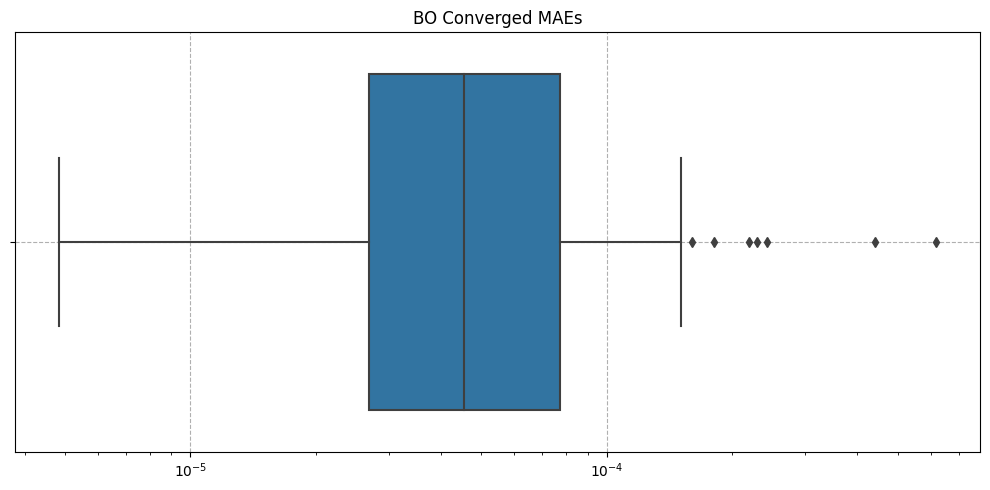

In [15]:
print(f"{np.median(conv_min_maes)}")

plt.figure(figsize=(10, 5))
plt.title("BO Converged MAEs")
sns.boxplot(x=conv_min_maes)
plt.xscale("log")
# plt.gca().xaxis.grid()
plt.grid(ls="--")
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()
